In [1]:
MODEL_ID = "28da8212-32f3-4680-bacd-0cd1c51bfe02"

MARKET1 = "DOW"
MARKET2 = "SPY"

PIPELINE_ID = "marketdirection"

# TODO : Pull out of pipeline config?
##### Specific to the data ##
NUM_FEATURES = (2 * 4) + 1
NUM_LABELS = 1
#############################

In [2]:
#
# Get dataset from MI API #
#

import pandas
import sys
import gc
import uuid
import numpy as np

!pip install --upgrade ../../../quantutils

import quantutils.dataset.pipeline as ppl
from quantutils.api.bluemix import CloudObjectStore, ObjectStore, Metrics, Logger
from quantutils.api.marketinsights import MarketInsights, Dataset
import quantutils.model.utils as mlutils
from quantutils.model.ml import Model

metrics = Metrics('cred/metrics_cred.json')
mi = MarketInsights('cred/MIOapi_cred.json')
objStore = ObjectStore('cred/object_storage_cred.json')
cos = CloudObjectStore('cred/ibm_cos_cred.json')
#log = Logger('MarketInsights-ML','cred/logging_cred.json')

# Logging helper function
tag = lambda x,y : "".join(["(", x, ":", str(y+1), ") "])

CONFIG = mi.get_model(MODEL_ID)
TRN_CNF = CONFIG['training']

MODEL_KEY = CloudObjectStore.generateKey([MODEL_ID, PIPELINE_ID, MARKET1, MARKET2])
COS_BUCKET = "marketinsights-weights"

mkt1 = mi.get_dataset(MARKET1, PIPELINE_ID)
mkt2 = mi.get_dataset(MARKET2, PIPELINE_ID)

# Interleave (part of the "added insight" for this model)
mkt1, mkt2, isect = ppl.intersect(mkt1,mkt2)
dataset = ppl.interleave(mkt1,mkt2)

# TODO : This should be config, probably as a proportion
TEST_SET_SIZE = 430
TRAINING_SET_SIZE = len(dataset) - TEST_SET_SIZE
WINDOW_SIZE = TRAINING_SET_SIZE

data_y, test_y = ppl.splitCol(dataset[TRAINING_SET_SIZE:], NUM_FEATURES)

# Create ML model
ffnn = Model(NUM_FEATURES, NUM_LABELS, CONFIG)

print("Done")

Processing /home/cwilkin/Development/repos/quantutils
  Running setup.py bdist_wheel for quantutils ... - \ | / - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-d2BN5c/wheels/2c/43/cd/2f55d0d246bef9749697646ecfc497d5893f0ca22cabe7befd
Successfully built quantutils
  Found existing installation: quantutils 1.0.0
    Uninstalling quantutils-1.0.0:
      Successfully uninstalled quantutils-1.0.0
Done


In [3]:
### 
### PREDICTIONS
###
tf.logging.set_verbosity(tf.logging.ERROR)

J = []
lam_opt = 0.01
THRESHOLD = 0.8


train({train_data_node: train_X, train_labels_node: train_y, lam: lam_opt},
      {train_data_node: val_X, train_labels_node: val_y, lam: lam_opt}, 
      THRESHOLD, 
      50)

# Show the fit and the loss over time.
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

x = np.array(range(0, len(J)))
ax1.plot(x, np.array(J).ravel())
ax1.set_ylabel("Loss")
ax1.set_xlabel("Iterations")
plt.show()

NameError: name 'tf' is not defined

In [ ]:
###
### LEARNING CURVES FOR TRAINING SET AND CROSS-VALIDATION SET 
###
train_losses = []
val_losses = [0]
perc_losses = [0]
tf.logging.set_verbosity(tf.logging.ERROR)

metrics = {
        "train_loss":[],
        "train_precision":[],
        "train_recall":[],
        "train_f":[],
        "val_loss":[],
        "val_precision":[],
        "val_recall":[],
        "val_f":[]
    }

myLam = 0.0
THRESHOLD = 0

for i in range(10,train_X.shape[0]+1,10):
    
    results = train({train_data_node: train_X[:i,:], train_labels_node: train_y[:i,:], lam: myLam},
            {train_data_node: val_X, train_labels_node: val_y, lam: myLam},
             THRESHOLD,
              1
            )
    
    metrics["train_loss"].append(results["train_loss"]["mean"])
    metrics["val_loss"].append(results["val_loss"]["mean"])
    metrics["val_precision"].append(results["val_precision"]["mean"])
    metrics["val_recall"].append(results["val_recall"]["mean"])
    metrics["val_f"].append(results["val_f"]["mean"])
        
# Show the loss as the amount of data increases
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

x = np.array(range(0, len(metrics["val_loss"]))) * 10
ax1.plot(x, np.array(metrics["train_loss"]).ravel())
ax1.plot(x, np.array(metrics["val_loss"]).ravel(),'r')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training Examples")
plt.show()

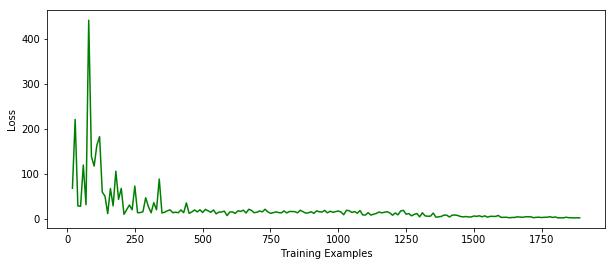

In [68]:
# Show the loss as the amount of data increases
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

x = np.array(range(0, len(metrics["val_loss"]))) * 10
#ax1.plot(x, np.array(train_losses).ravel())
#ax1.plot(x, np.array(val_losses).ravel(),'r')
ax1.plot(x[2:], (np.array(((np.array(metrics["val_loss"])) ))[2:]).ravel(),'g')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training Examples")
plt.show()

Training...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide


Iterations : 10 Lambda : 0.00, Threshold : 0.90
Mean Validation loss : 2.04, precision : 0.62, recall : 0.67, F : 0.64
Sigma Validation loss : 0.38, precision : 0.03, recall : 0.08, F : 0.04
Training...
Iterations : 10 Lambda : 0.01, Threshold : 0.90
Mean Validation loss : 0.90, precision : 0.65, recall : 0.27, F : 0.38
Sigma Validation loss : 0.06, precision : 0.04, recall : 0.04, F : 0.03
Optimal value for lambda is 0.01


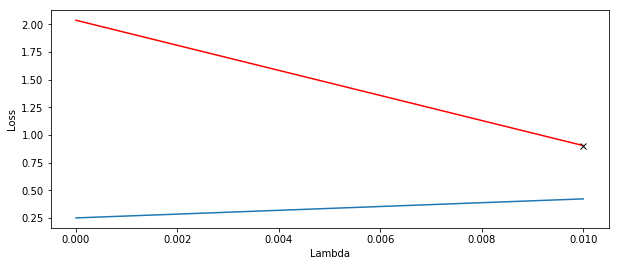

In [47]:
###
### LAMBDA OPTIMIZATION
###

tf.logging.set_verbosity(tf.logging.ERROR)

#lams = [0.0, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1]#, 0.3, 1.0, 3.0, 10.0]
#lams = np.arange(0.02,.04, .001)
lams = [0.0, 0.01]

metrics = {
        "train_loss":[],
        "train_precision":[],
        "train_recall":[],
        "train_f":[],
        "val_loss":[],
        "val_precision":[],
        "val_recall":[],
        "val_f":[]
    }

for i in lams:
    
    results = train({train_data_node: train_X, train_labels_node: train_y, lam: i},
            {train_data_node: val_X, train_labels_node: val_y, lam: i},
             THRESHOLD,
              10
            )
    
    metrics["train_loss"].append(results["train_loss"]["mean"])
    metrics["val_loss"].append(results["val_loss"]["mean"])
     

lam_opt = lams[np.argmin(metrics["val_loss"])]
print("Optimal value for lambda is %s" % lam_opt)
    
# Show the loss as the value of lambda changes
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

ax1.plot(lams, np.array(metrics["train_loss"]).ravel())
ax1.plot(lams, np.array(metrics["val_loss"]).ravel(),'r')
ax1.plot(lams[np.argmin(metrics["val_loss"])], metrics["val_loss"][np.argmin(metrics["val_loss"])], 'x', color='black')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Lambda")
plt.show()

In [ ]:
###
### THRESHOLD OPTIMIZATION
###

tf.logging.set_verbosity(tf.logging.ERROR)

mylam = 0.0
threshold = 0
thresholds = [.5, .8, .9, .99, .999]
lams = [0.0, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 1.0]

for i in thresholds:
    
    results = train({train_data_node: train_X, train_labels_node: train_y, lam: mylam},
            {train_data_node: val_X, train_labels_node: val_y, lam: mylam},
             i
            ) 
    
print("Done")


In [7]:
# Function to take dates, dataset info for those dates
def predict(model, timestamps, dataset, weights):

    # Load timestamps from weights db (or load all weights data)
    wPeriods = weights["timestamp"].values

    # x = for each dataset timestamp, match latest available weight timestamp
    latestPeriods = np.zeros(len(timestamps)) 
    uniqueWPeriods = np.unique(wPeriods)  # q
    mask = timestamps>=np.min(uniqueWPeriods)
    latestPeriods[mask] = [uniqueWPeriods[uniqueWPeriods<=s][-1] for s in timestamps[mask]]

    # for each non-duplicate timestamp in x, load weights into model for that timestamp
    results = np.empty((len(dataset), NUM_LABELS))
    for x in np.unique(latestPeriods):
        # run dataset entries matching that timestamp through model, save results against original timestamps
        mask = latestPeriods==x
        results[mask] = np.nanmean(model.predict(weights[wPeriods==x].values[:,1:], dataset[mask]), axis=0)
    
    return results   

In [4]:
loadedData = mi.get_dataset(MARKET1, PIPELINE_ID).iloc[:,:-1][-219:]
timestamps = loadedData.index.astype(np.int64) // 10**9
dataset = loadedData.reset_index(drop=True)

import time
weights = cos.get_csv(COS_BUCKET, MODEL_KEY) 

In [8]:
%time predict(ffnn, timestamps[:5], dataset[:5], weights)

CPU times: user 24.7 ms, sys: 928 µs, total: 25.6 ms
Wall time: 22.3 ms


array([[0.51830869],
       [0.64817482],
       [0.36570716],
       [0.45089174],
       [0.37488978]])

In [61]:
from quantutils.api.marketinsights import MarketInsights, Dataset

In [9]:
Dataset.csvtojson(loadedData, MARKET1, PIPELINE_ID)

'{"index": ["2016-07-06T15:00:00", "2016-07-07T15:00:00", "2016-07-08T15:00:00", "2016-07-11T15:00:00", "2016-07-12T15:00:00", "2016-07-13T15:00:00", "2016-07-14T15:00:00", "2016-07-15T15:00:00", "2016-07-18T15:00:00", "2016-07-19T15:00:00", "2016-07-20T15:00:00", "2016-07-21T15:00:00", "2016-07-22T15:00:00", "2016-07-25T15:00:00", "2016-07-26T15:00:00", "2016-07-27T15:00:00", "2016-07-28T15:00:00", "2016-07-29T15:00:00", "2016-08-01T15:00:00", "2016-08-02T15:00:00", "2016-08-03T15:00:00", "2016-08-04T15:00:00", "2016-08-05T15:00:00", "2016-08-08T15:00:00", "2016-08-09T15:00:00", "2016-08-10T15:00:00", "2016-08-11T15:00:00", "2016-08-12T15:00:00", "2016-08-15T15:00:00", "2016-08-16T15:00:00", "2016-08-17T15:00:00", "2016-08-18T15:00:00", "2016-08-19T15:00:00", "2016-08-22T15:00:00", "2016-08-23T15:00:00", "2016-08-24T15:00:00", "2016-08-25T15:00:00", "2016-08-26T15:00:00", "2016-08-29T15:00:00", "2016-08-30T15:00:00", "2016-08-31T15:00:00", "2016-09-01T15:00:00", "2016-09-02T15:00:00",

In [6]:
ffnn.NUM_LABELS

1